<a href="https://colab.research.google.com/github/OumGhaith/Comparative_Steel_Inspection_using_Densnet_and_k_cross_validation/blob/main/Comparative_Steel_EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Total images: 1800, Classes: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

=== Fold 1/5 ===
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 185MB/s]


Fold 1 Accuracy: 100.00%

=== Fold 2/5 ===
Fold 2 Accuracy: 100.00%

=== Fold 3/5 ===
Fold 3 Accuracy: 100.00%

=== Fold 4/5 ===
Fold 4 Accuracy: 100.00%

=== Fold 5/5 ===
Fold 5 Accuracy: 100.00%


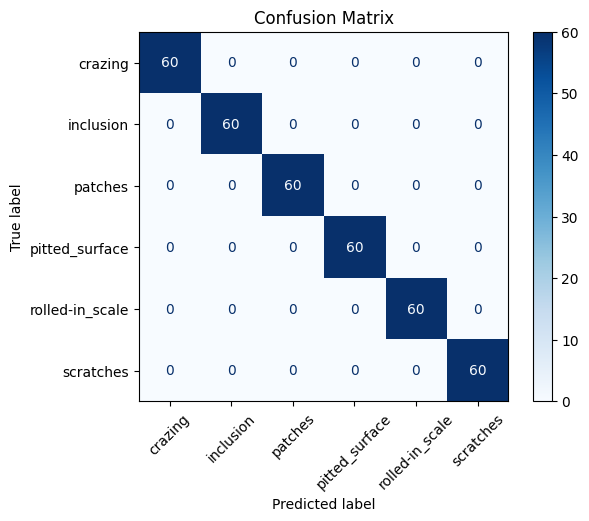

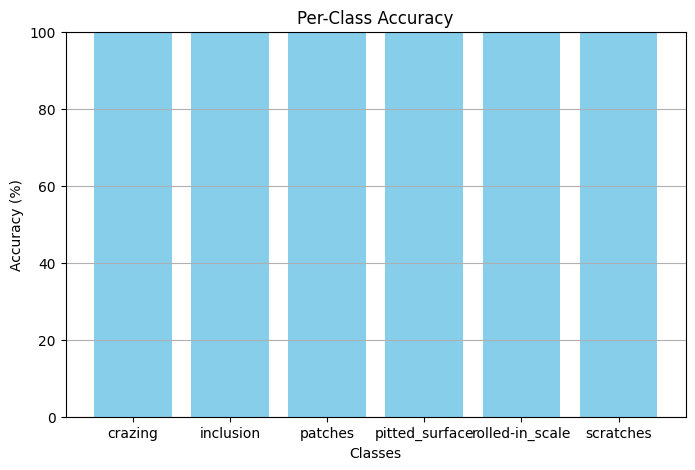

Class crazing: 100.00%
Class inclusion: 100.00%
Class patches: 100.00%
Class pitted_surface: 100.00%
Class rolled-in_scale: 100.00%
Class scratches: 100.00%


In [ ]:
# =========================================
# EfficientNet-B0 K-Fold Classification
# =========================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# -----------------------------
# 1️⃣ Device Configuration
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2️⃣ Image Transforms
# -----------------------------
# Resize images, normalize and apply data augmentation
transform = transforms.Compose([
    transforms.Resize((224,224)),            # EfficientNet-B0 expects 224x224
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.ToTensor(),                   # Convert PIL->Tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # Normalize
])

# -----------------------------
# 3️⃣ Load Datasets
# -----------------------------
train_dataset = ImageFolder('/content/drive/MyDrive/steel_images/train_dataset', transform=transform)
test_dataset  = ImageFolder('/content/drive/MyDrive/steel_images/test_dataset', transform=transform)

# Combine datasets for K-Fold
all_dataset = train_dataset + test_dataset
all_labels = np.array([label for _, label in all_dataset])
print(f"Total images: {len(all_dataset)}, Classes: {train_dataset.classes}")

# -----------------------------
# 4️⃣ K-Fold Setup
# -----------------------------
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Track fold metrics
fold_results = []
final_model = None
final_val_subset = None
final_val_loader = None

# -----------------------------
# 5️⃣ K-Fold Training Loop
# -----------------------------
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):
    print(f"\n=== Fold {fold+1}/{k_folds} ===")

    # Create Subsets
    train_subset = Subset(all_dataset, train_idx)
    val_subset   = Subset(all_dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_subset, batch_size=16, shuffle=False)

    # -----------------------------
    # 5a️⃣ Load EfficientNet-B0
    # -----------------------------
    from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
    weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Pretrained on ImageNet
    model = efficientnet_b0(weights=weights)

    # Replace final classifier for our 6 classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))
    model = model.to(device)

    # -----------------------------
    # 5b️⃣ Loss & Optimizer
    # -----------------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # -----------------------------
    # 5c️⃣ Training Loop
    # -----------------------------
    epochs = 10
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))

    # -----------------------------
    # 5d️⃣ Evaluate Fold
    # -----------------------------
    model.eval()
    all_true, all_pred = [], []
    wellclassified, misclassified = [], []

    with torch.no_grad():
        for img, label in val_subset:
            img_input = img.unsqueeze(0).to(device)
            output = model(img_input)
            pred = torch.argmax(output, dim=1).item()
            all_true.append(label)
            all_pred.append(pred)
            # Track well/misclassified images
            if pred == label:
                wellclassified.append((img, label, pred))
            else:
                misclassified.append((img, label, pred))

    acc = accuracy_score(all_true, all_pred) * 100
    print(f"Fold {fold+1} Accuracy: {acc:.2f}%")
    fold_results.append(acc)

    # Save last fold for inspection
    if fold == k_folds - 1:
        final_model = model
        final_val_subset = val_subset
        final_val_loader = val_loader
        final_train_losses, final_val_losses = train_losses, val_losses

# -----------------------------
# 6️⃣ Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# -----------------------------
# 7️⃣ Per-Class Accuracy
# -----------------------------
classes = train_dataset.classes
class_correct = np.zeros(len(classes))
class_total = np.zeros(len(classes))

for _, true, pred in wellclassified + misclassified:
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

class_acc = class_correct / class_total * 100
plt.figure(figsize=(8,5))
plt.bar(classes, class_acc, color='skyblue')
plt.ylabel("Accuracy (%)")
plt.xlabel("Classes")
plt.title("Per-Class Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()

for cls, acc in zip(classes, class_acc):
    print(f"Class {cls}: {acc:.2f}%")

# -----------------------------
# 8️⃣ Visualize Misclassified & Well-Classified
# -----------------------------
fig = plt.figure(figsize=(12,6))
for i in range(min(5, len(wellclassified))):
    img, t, p = wellclassified[i]
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5 + 0.5)
    ax.set_title(f"Well: True={classes[t]}\nPred={classes[p]}")
    ax.axis('off')

for i in range(min(5, len(misclassified))):
    img, t, p = misclassified[i]
    ax = fig.add_subplot(2,5,i+6)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5 + 0.5)
    ax.set_title(f"Mis: True={classes[t]}\nPred={classes[p]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# -----------------------------
# 9️⃣ Save Model
# -----------------------------
model_path = '/content/drive/MyDrive/steel_images/efficientnet_b0_final.pt'
torch.save(model.state_dict(), model_path)
print(f"EfficientNet-B0 model saved at: {model_path}")

# -----------------------------
# 🔟 Inference Time
# -----------------------------
dummy_input = torch.randn(1,3,224,224).to(device)
model.eval()
# Warm-up
for _ in range(10):
    _ = model(dummy_input)
# Timing
start_time = time.time()
for _ in range(100):
    _ = model(dummy_input)
inference_time = (time.time() - start_time)/100 * 1000  # ms per image
print(f"Average inference time: {inference_time:.2f} ms per image")


Class crazing: 100.00%
Class inclusion: 100.00%
Class patches: 100.00%
Class pitted_surface: 100.00%
Class rolled-in_scale: 100.00%
Class scratches: 100.00%


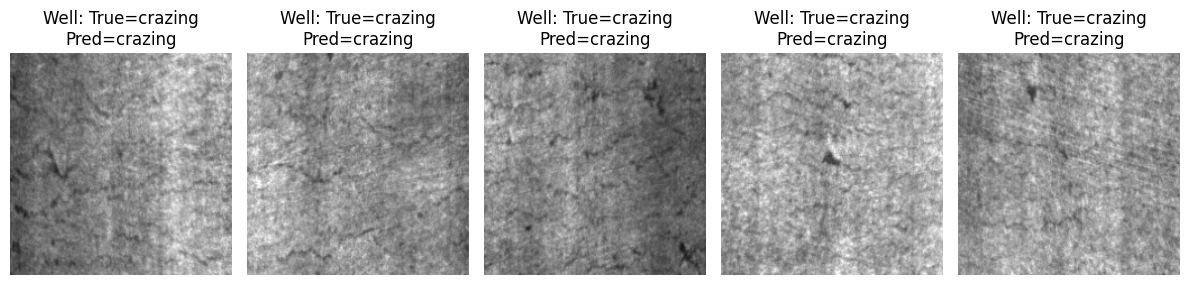

EfficientNet-B0 model saved at: /content/drive/MyDrive/steel_images/efficientnet_b0_final.pt
Average inference time: 14.05 ms per image


In [3]:
for cls, acc in zip(classes, class_acc):
    print(f"Class {cls}: {acc:.2f}%")

# -----------------------------
# 8️⃣ Visualize Misclassified & Well-Classified
# -----------------------------
fig = plt.figure(figsize=(12,6))
for i in range(min(5, len(wellclassified))):
    img, t, p = wellclassified[i]
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5 + 0.5)
    ax.set_title(f"Well: True={classes[t]}\nPred={classes[p]}")
    ax.axis('off')

for i in range(min(5, len(misclassified))):
    img, t, p = misclassified[i]
    ax = fig.add_subplot(2,5,i+6)
    ax.imshow(img.permute(1,2,0).cpu().numpy()*0.5 + 0.5)
    ax.set_title(f"Mis: True={classes[t]}\nPred={classes[p]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# -----------------------------
# 9️⃣ Save Model
# -----------------------------
model_path = '/content/drive/MyDrive/steel_images/efficientnet_b0_final.pt'
torch.save(model.state_dict(), model_path)
print(f"EfficientNet-B0 model saved at: {model_path}")

# -----------------------------
# 🔟 Inference Time
# -----------------------------
dummy_input = torch.randn(1,3,224,224).to(device)
model.eval()
# Warm-up
for _ in range(10):
    _ = model(dummy_input)
# Timing
start_time = time.time()
for _ in range(100):
    _ = model(dummy_input)
inference_time = (time.time() - start_time)/100 * 1000  # ms per image
print(f"Average inference time: {inference_time:.2f} ms per image")

In [4]:
print('Yousra, You are awesome')

Yousra, You are awesome
